## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l1_ratio=0.0, l2_ratio=0.001):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# judging from previous exercises: 
# batch normalization works best at 128, pre-activation 
# regularization works best at l1 0, l2 0.0001
# dropout rate best around 0.01

## 超參數設定
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = [128, 256]
Dropout_EXP = [0.0, 0.1, 0.2]
MOMENTUM = 0.95

In [7]:
results = {}

for i, (bz, drp_rate) in enumerate(itertools.product(BATCH_SIZE, Dropout_EXP)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i, batch_size: %s, dropout_rate: %.2f, l1_l2: 0_0.001" % (i, bz, drp_rate))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drp_rate)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, batch_size: 128, dropout_rate: 0.00, l1_l2: 0_0.001
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________________

50000/50000 [==============================] - 24s 478us/step - loss: 1.7953 - accuracy: 0.3997 - val_loss: 2.3259 - val_accuracy: 0.2625
Epoch 41/50
50000/50000 [==============================] - 24s 480us/step - loss: 1.7978 - accuracy: 0.4004 - val_loss: 2.3382 - val_accuracy: 0.2919
Epoch 42/50
50000/50000 [==============================] - 24s 478us/step - loss: 1.7984 - accuracy: 0.3997 - val_loss: 2.0986 - val_accuracy: 0.2784
Epoch 43/50
50000/50000 [==============================] - 24s 479us/step - loss: 1.7910 - accuracy: 0.4014 - val_loss: 2.0792 - val_accuracy: 0.3108
Epoch 44/50
50000/50000 [==============================] - 24s 482us/step - loss: 1.7909 - accuracy: 0.4029 - val_loss: 2.1835 - val_accuracy: 0.2963
Epoch 45/50
50000/50000 [==============================] - 24s 483us/step - loss: 1.7990 - accuracy: 0.4006 - val_loss: 2.2418 - val_accuracy: 0.2699
Epoch 46/50
50000/50000 [==============================] - 24s 485us/step - loss: 1.7945 - accuracy: 0.4015 - va

50000/50000 [==============================] - 23s 456us/step - loss: 2.0210 - accuracy: 0.3389 - val_loss: 2.6190 - val_accuracy: 0.1681
Epoch 30/50
50000/50000 [==============================] - 23s 457us/step - loss: 2.0143 - accuracy: 0.3389 - val_loss: 2.0852 - val_accuracy: 0.3068
Epoch 31/50
50000/50000 [==============================] - 23s 458us/step - loss: 2.0103 - accuracy: 0.3404 - val_loss: 2.1990 - val_accuracy: 0.2580
Epoch 32/50
50000/50000 [==============================] - 23s 458us/step - loss: 2.0133 - accuracy: 0.3395 - val_loss: 2.6553 - val_accuracy: 0.1689
Epoch 33/50
50000/50000 [==============================] - 23s 459us/step - loss: 2.0093 - accuracy: 0.3417 - val_loss: 2.3643 - val_accuracy: 0.2290
Epoch 34/50
50000/50000 [==============================] - 23s 458us/step - loss: 2.0123 - accuracy: 0.3410 - val_loss: 2.1214 - val_accuracy: 0.2842
Epoch 35/50
50000/50000 [==============================] - 23s 457us/step - loss: 2.0160 - accuracy: 0.3415 - va

50000/50000 [==============================] - 25s 501us/step - loss: 2.2031 - accuracy: 0.3178 - val_loss: 2.4971 - val_accuracy: 0.2319
Epoch 19/50
50000/50000 [==============================] - 23s 462us/step - loss: 2.1985 - accuracy: 0.3207 - val_loss: 2.6449 - val_accuracy: 0.1851
Epoch 20/50
50000/50000 [==============================] - 23s 461us/step - loss: 2.2126 - accuracy: 0.3158 - val_loss: 2.4652 - val_accuracy: 0.2192
Epoch 21/50
50000/50000 [==============================] - 23s 462us/step - loss: 2.1969 - accuracy: 0.3217 - val_loss: 2.8420 - val_accuracy: 0.1864
Epoch 22/50
50000/50000 [==============================] - 23s 470us/step - loss: 2.1917 - accuracy: 0.3179 - val_loss: 2.5063 - val_accuracy: 0.1857
Epoch 23/50
50000/50000 [==============================] - 23s 467us/step - loss: 2.1816 - accuracy: 0.3179 - val_loss: 2.2965 - val_accuracy: 0.2639
Epoch 24/50
50000/50000 [==============================] - 24s 471us/step - loss: 2.1852 - accuracy: 0.3205 - va

50000/50000 [==============================] - 17s 334us/step - loss: 1.8335 - accuracy: 0.4145 - val_loss: 2.3855 - val_accuracy: 0.2351
Epoch 8/50
50000/50000 [==============================] - 17s 332us/step - loss: 1.8217 - accuracy: 0.4153 - val_loss: 2.3708 - val_accuracy: 0.2415
Epoch 9/50
50000/50000 [==============================] - 17s 332us/step - loss: 1.8008 - accuracy: 0.4180 - val_loss: 2.4378 - val_accuracy: 0.2059
Epoch 10/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.7950 - accuracy: 0.4185 - val_loss: 2.2180 - val_accuracy: 0.2855
Epoch 11/50
50000/50000 [==============================] - 17s 334us/step - loss: 1.7831 - accuracy: 0.4193 - val_loss: 2.5868 - val_accuracy: 0.2093
Epoch 12/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.7739 - accuracy: 0.4216 - val_loss: 1.9862 - val_accuracy: 0.3433
Epoch 13/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.7672 - accuracy: 0.4243 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 19s 374us/step - loss: 2.7839 - accuracy: 0.3467 - val_loss: 2.4865 - val_accuracy: 0.2605
Epoch 2/50
50000/50000 [==============================] - 17s 349us/step - loss: 2.2417 - accuracy: 0.3587 - val_loss: 2.4707 - val_accuracy: 0.2394
Epoch 3/50
50000/50000 [==============================] - 18s 353us/step - loss: 2.2049 - accuracy: 0.3609 - val_loss: 2.4301 - val_accuracy: 0.2475
Epoch 4/50
50000/50000 [==============================] - 18s 364us/step - loss: 2.1660 - accuracy: 0.3636 - val_loss: 2.4775 - val_accuracy: 0.2456
Epoch 5/50
50000/50000 [==============================] - 18s 354us/step - loss: 2.1417 - accuracy: 0.3635 - val_loss: 2.4091 - val_accuracy: 0.2344
Epoch 6/50
50000/50000 [==============================] - 18s 360us/step - loss: 2.1099 - accuracy: 0.3632 - val_loss: 2.5049 - val_accuracy: 0.2145
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 356us/step - loss: 2.8412 - accuracy: 0.3333 - val_loss: 2.6732 - val_accuracy: 0.2168
Epoch 2/50
50000/50000 [==============================] - 17s 335us/step - loss: 2.3376 - accuracy: 0.3467 - val_loss: 3.0200 - val_accuracy: 0.1701
Epoch 3/50
50000/50000 [==============================] - 17s 337us/step - loss: 2.3331 - accuracy: 0.3451 - val_loss: 4.3320 - val_accuracy: 0.1061
Epoch 4/50
50000/50000 [==============================] - 17s 333us/step - loss: 2.3306 - accuracy: 0.3464 - val_loss: 2.5398 - val_accuracy: 0.2597
Epoch 5/50
50000/50000 [==============================] - 17s 343us/step - loss: 2.2959 - accuracy: 0.3462 - val_loss: 3.0632 - val_accuracy: 0.1643
Epoch 6/50
50000/50000 [==============================] - 17s 336us/step - loss: 2.2865 - accuracy: 0.3452 - val_loss: 2.9030 - val_accuracy: 0.1619
Epoch 7/50
50000/50000 [==============================] 

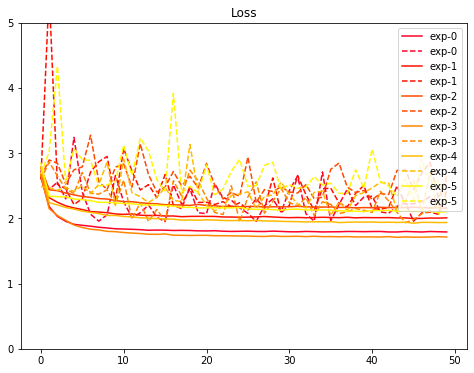

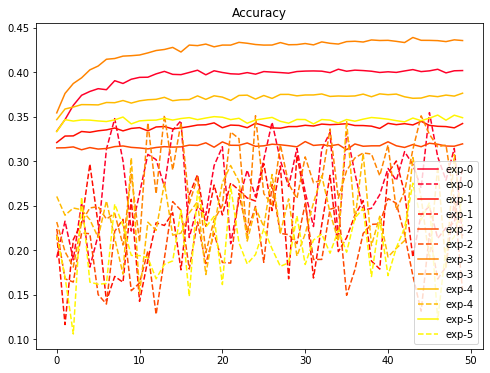

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()